### Getting Data from source

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip 'drive/MyDrive/Datasets/archive'

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

### Packages

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf


In [4]:
tf.__version__

'2.8.0'

## Caption Dataset

In [5]:
caption_file = "captions.txt"

with open(caption_file, "r") as f:
    text = f.readlines()
    
text_list = [x.split('\n')[:-1][0] for x in text]
image_list = [x.split(',')[0] for x in text_list][1:]
caption_list = [''.join(x.split(',')[1:]) for x in text_list][1:]

df = pd.DataFrame({'image' : image_list,
                   'caption' : caption_list})

uncleaned_captions_dict = dict(df.groupby('image')['caption'].apply(list))

In [6]:
uncleaned_captions_dict['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
## Dividing the images into train and validation set
from sklearn.model_selection import train_test_split

train_image_names, val_image_names = train_test_split(list(uncleaned_captions_dict.keys()), train_size = 0.8)

print(len(train_image_names))
print(len(val_image_names))

6472
1619


In [8]:
train_image_names = train_image_names
val_image_names = val_image_names

## Preparing captions

In [9]:
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
## Lower case
## Punctuation removal
## Remove numerical numbers/digits
## Remove one character words
## Add start and end token'
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

## Cleaning each caption for every image ----------------------
def clean(captions_dictionary):
  cleaned_dict = dict()
  for key, captions in captions_dictionary.items():
    for i, caption in enumerate (captions): ## Looping through the list of captions
      caption_nopunct = re.sub(r"[^a-zA-Z0-9]+", ' ', caption.lower())
      
      # Split the caption into separate words, and collect all words which are more than 
      # one character and which contain only alphabets (ie. discard words with mixed alpha-numerics)
      clean_words = [word for word in caption_nopunct.split() if ((len(word) > 1) and (word.isalpha()))]
      
      # Join those words into a string
      caption_new = ' '.join(clean_words)
      
      # Replace the old caption in the captions list with this new cleaned caption
      captions[i] = caption_new
    cleaned_dict[key] = captions
  
  return cleaned_dict

## Adding tokens to each caption and re-creating the dictionary ----------------------
def add_token(captions):
  for i, caption in enumerate(captions):
    captions[i] = 'startseq ' + caption + ' endseq'
  return captions

def subset_data_dict(image_dict, image_names): ## Pass different image names for train and validation
  dict_1 = { image_name : add_token(captions) for image_name,captions in image_dict.items() if image_name in image_names}
  return dict_1


####### Step 1 - Cleaning all captions  #######
captions_dict = clean(uncleaned_captions_dict)
training_dict = subset_data_dict(captions_dict, train_image_names)
val_dict = subset_data_dict(captions_dict, val_image_names)

In [11]:
####### Step 2 - Convert words to word ids  #######

#--------------------------------------------------
# Fit a Keras tokenizer given caption descriptions
# This tokenizer will be used to encode the word in captions as numbers
#--------------------------------------------------

def create_tokenizer(data_dict):
  captions = [caption for key, captions in data_dict.items() for caption in captions] ## Flat list of all captions
  max_len_captions = max(len(caption.split()) for caption in captions)
  
  # Initialise a Keras Tokenizer
  tokenizer = Tokenizer()
  
  # Fit it on the captions so that it prepares a vocabulary of all words
  tokenizer.fit_on_texts(captions)
  
  # Get the size of the vocabulary
  vocab_size = len(tokenizer.word_index) + 1

  return (tokenizer, vocab_size, max_len_captions)

tokenizer, vocab_size, max_len_captions = create_tokenizer(training_dict)

In [12]:
####### Step 3 - Prepare for tensorflow dataset object  #######
image_dir = 'Images'

# def pad_text(text, max_length): 
#   text = pad_sequences([text], maxlen=max_length, padding='post')[0]
#   return text

def data_prep(data_dict, tokenizer, max_length, vocab_size):
  X, y = list(), list()

  # For each image and list of captions
  for image_name, captions in data_dict.items():
    image_name = image_dir + '/'+ image_name
    image_name_no_ext = image_name.split('.')[0]

    # For each caption in the list of captions
    for caption in captions:

      # Convert the caption words into a list of word indices
      word_idxs = tokenizer.texts_to_sequences([caption])[0]

      # Pad the input text to the same fixed length
      pad_idxs = pad_sequences([word_idxs], maxlen=max_length, padding='post')[0]
      # pad_idxs = pad_text(word_idxs, max_length)
          
      X.append(image_name_no_ext)
      y.append(pad_idxs)
  
  return np.array(X), np.array(y)
  return X, y

## Pass the cleaned captions
## A Tokenizer fitted only on training data
## Max length of captions (to be used for padding) 

train_X, train_y = data_prep(training_dict, tokenizer, max_len_captions,vocab_size)
val_X, val_y = data_prep(val_dict, tokenizer, max_len_captions, vocab_size)

In [13]:
train_X[0]

'Images/1000268201_693b08cb0e'

In [14]:
train_y[0]

array([   1,   43,    3,   87,  162,    6,  117,   51,  390,   11,  386,
          3,   27, 4620,  658,    2,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [15]:
vocab_size

7634

## Preparing Images

In [16]:
class image_encoder(keras.Model):
    def __init__(self, pre_trained_model):
      super().__init__(trainable=True)
      self.trained_model = pre_trained_model
      
    def call(self,x): 
      model_input = self.trained_model.input
      # model_input = self.trained_model.preprocess_input(x) 
      hidden_layer = self.trained_model.layers[-1].output
      model = keras.Model(inputs = model_input, outputs = hidden_layer)
      encoder_hidden_state = model(x)
      # y = self.ff(encoder_hidden_state)
      # y = tf.nn.relu(y)

      return encoder_hidden_state

    def model(self):
      x = keras.Input(shape = (2048, 2048,3))
      return keras.Model(inputs = [x], outputs = self.call(x))


## Initializing the encoder -------
inception = keras.applications.InceptionV3(include_top=False,weights='imagenet')

x = keras.Input(shape = (2048,2048,3))
image_features_extract_model = image_encoder(inception)

image_features_extract_model.model().summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2048, 2048, 3)]   0         
                                                                 
 model (Functional)          (None, None, None, 2048)  21802784  
                                                                 
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
_________________________________________________________________


In [17]:
train_image_names[0]

'2207244634_1db1a1890b.jpg'

In [18]:
def load_image(image_path):
    image_path_1 = image_path + '.jpg'
    img = tf.io.read_file(image_path_1)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Get unique images
from tqdm import tqdm

train_image_names = [x.split('.')[0] for x in train_image_names]
val_image_names = [x.split('.')[0] for x in val_image_names]

image_dir = "Images/"
training_image_paths = [image_dir + name for name in train_image_names]
val_image_paths = [image_dir + name for name in val_image_names]

training_image_paths = training_image_paths
val_image_paths = val_image_paths

encode_train = sorted(set(training_image_paths))
encode_val = sorted(set(val_image_paths))

## Preparing Train ------------
train_image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
train_image_dataset = train_image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(train_image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for x, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, x.numpy())


## Preparing Validation ------------
val_image_dataset = tf.data.Dataset.from_tensor_slices(encode_val)
val_image_dataset = val_image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(val_image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for x, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, x.numpy())



100%|██████████| 102/102 [00:40<00:00,  2.49it/s]


In [19]:
path_of_feature

'Images/99679241_adc853a5c0'

In [20]:
# x

In [21]:
import os

len([x for x in os.listdir('Images') if x.split('.')[-1] == 'npy'])

8091

In [22]:
train_X[0]

'Images/1000268201_693b08cb0e'

## Preparing tensorfow datasets

In [23]:
####### Step 4 - Prepare tensorflow datasets  #######

## Wrap the training data in a Tensorflow Dataset object so that it can be efficiently fetched and fed, one batch at a time, to the model during training. 
## The data is fetched lazily so that it doesn’t all have to be in memory at the same time.

BATCH_SIZE = 64
BUFFER_SIZE = 1000

# Load the numpy files
def map_func(img_name, cap):
   
   img_tensor = np.load(img_name.decode('utf-8')+'.npy')  ## Reading the feature vectors of the images from pre-trained CNN
   return img_tensor, cap

train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_X, val_y))

############## Training Data  ##############
# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

############## Validation Data  ##############
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



In [24]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>

In [25]:
# img_name = 'Images/1095980313_3c94799968.npy'
# img_tensor = np.load(img_name)

In [26]:
for x,y in train_dataset.take(1).as_numpy_iterator():    
    print(x.shape, y.shape)
    # print('\n')
    # print(x)
    # print(y)

(64, 64, 2048) (64, 35)


In [27]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, Input, TimeDistributed, LayerNormalization, GlobalAveragePooling1D,BatchNormalization, Dropout

## Architecture

In [28]:
class Attention(tf.keras.Model):
  def __init__(self, units):
    super().__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [29]:
class feature_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super().__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [30]:
class decoder(keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
      super().__init__()
      self.units = units

      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
      self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True)
      self.fc1 = tf.keras.layers.Dense(self.units)
      self.fc2 = tf.keras.layers.Dense(vocab_size)

      # self.attention = Attention()
      self.attention = Attention(self.units)

    def call(self,x,features,hidden):
      context_vector, attention_weights = self.attention(features, hidden)

      x = self.embedding(x)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
      output, state = self.gru(x)
      
      x = self.fc1(output)

      x = tf.reshape(x, (-1, x.shape[2]))

      # output shape == (batch_size * max_length, vocab)
      x = self.fc2(x) ## x is the final output corresponding to pedicted word

      return x, state, attention_weights

    def reset_state(self, batch_size):
      return tf.zeros((batch_size, self.units))
 

### Training Loop

In [31]:
## 
embedding_dim = 256
units = 512
BATCH_SIZE = 64
train_loss_plot = []
val_loss_plot = []

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

## Initialising the encoder and decoder
CNN_Encoder = feature_Encoder(embedding_dim)
RNN_Decoder = decoder(embedding_dim, units, vocab_size)

## Optimizer
## Loss
## Metrics
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [32]:
@tf.function
def train_step(img_tensor, target):
  ## Img_tensor is output of tf.data
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = RNN_Decoder.reset_state(batch_size=target.shape[0])
  # print('Completed Hidden')

  dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)
  # print('Completed Decoder input')

  with tf.GradientTape() as tape:
      features = CNN_Encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          # Previous Hidden state of GRU is passed along with feature vector from encoder
          predictions, hidden, _ = RNN_Decoder(dec_input, features, hidden) 

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
  # print('Finished Forward pass')
  total_loss = (loss / int(target.shape[1]))

  trainable_variables = CNN_Encoder.trainable_variables + RNN_Decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  # print('Starting backprop')
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  # print('Completed gradient computation and parameter update')

  return loss, total_loss

In [33]:
@tf.function
def val_step(img_tensor, target):
    val_loss = 0

    hidden = RNN_Decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)
    
    features = CNN_Encoder(img_tensor)
    for i in range(1, target.shape[1]):
      predictions, hidden, _ = RNN_Decoder(dec_input, features, hidden) 
      val_loss += loss_function(target[:, i], predictions)
    
    avg_val_loss = (val_loss / int(target.shape[1]))

    return val_loss, avg_val_loss



In [34]:
train_num_steps = len(train_X) // BATCH_SIZE
val_num_steps = len(val_X) // BATCH_SIZE

import time
start_epoch = 0
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    print(f'EPOCH ----- {epoch}')
    start = time.time()

    ## To track loss across epochs
    total_train_loss = 0 
    total_val_loss = 0

    ## Train Step
    print('I am starting to train')
    for (batch, (img_tensor, target)) in enumerate(train_dataset): 
        print(f'Batch Number --- {batch}')
        batch_train_loss, t_loss = train_step(img_tensor, target) ## t_loss :- average loss of 32 data points in a batch
        total_train_loss += t_loss ## Total Loss in an epoch

        ## After completion of every 100 batches in epoch, print loss
        if batch % 100 == 0:
            average_batch_loss = batch_train_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

    train_loss_plot.append(total_train_loss / train_num_steps)

    ## Validation Step
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        batch_test_loss, v_loss = val_step(img_tensor, target)
        total_val_loss += v_loss

        if batch % 100 == 0:
            average_batch_loss = batch_test_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    
    # storing the epoch end loss value to plot later
    val_loss_plot.append(total_val_loss / val_num_steps)
    
    print(f'Epoch {epoch+1} Train Loss {total_train_loss/train_num_steps:.6f} Val Loss {total_val_loss/val_num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Batch Number --- 382
Batch Number --- 383
Batch Number --- 384
Batch Number --- 385
Batch Number --- 386
Batch Number --- 387
Batch Number --- 388
Batch Number --- 389
Batch Number --- 390
Batch Number --- 391
Batch Number --- 392
Batch Number --- 393
Batch Number --- 394
Batch Number --- 395
Batch Number --- 396
Batch Number --- 397
Batch Number --- 398
Batch Number --- 399
Batch Number --- 400
Epoch 1 Batch 400 Loss 1.2263
Batch Number --- 401
Batch Number --- 402
Batch Number --- 403
Batch Number --- 404
Batch Number --- 405
Batch Number --- 406
Batch Number --- 407
Batch Number --- 408
Batch Number --- 409
Batch Number --- 410
Batch Number --- 411
Batch Number --- 412
Batch Number --- 413
Batch Number --- 414
Batch Number --- 415
Batch Number --- 416
Batch Number --- 417
Batch Number --- 418
Batch Number --- 419
Batch Number --- 420
Batch Number --- 421
Batch Number --- 422
Batch Number --- 423
Batch Number --- 424
Batch Number --- 425
Batch Number --- 426
Batch Number --- 427
Batc

## Inference
- Greedy Search is used to predict the output by picking the word with the highest probability at each timestep.
- Teacher Forcing cannot be done, The prediction of previous step needs to be passed to the decoder for next step prediction


In [41]:
def inference(image, max_length):  ## Max Length of caption to be generated
    ## Capturing the areas when a word is predicted 
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = RNN_Decoder.reset_state(batch_size=1)

    ## Creating the Feature vector
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)  ## Shape(64,2048)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = CNN_Encoder(img_tensor_val)

    ## Decoder prediction start
    dec_input = tf.expand_dims([tokenizer.word_index['startseq']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = RNN_Decoder(dec_input,features,hidden)
        
        ## Drawing 1 sample from the bag of predicted words (Highest probability is chosen) 
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        ## Checking for the end of sentence
        if tokenizer.index_word[predicted_id] == 'endseq':
            return result

        ## Appending the predicted word to the decoder input for next step
        dec_input = tf.expand_dims([predicted_id], 0)

    return result
    


In [64]:
## Generating caption for new image
image_name = 'Test'
image_path = image_name
max_caption_words = 20
result = inference(image_path, max_caption_words)

In [61]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("Test.jpg")

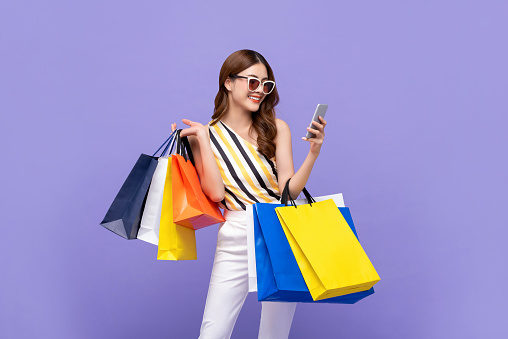

In [62]:
cv2_imshow(img)

In [65]:
print('Caption as generated by our network :')
print('\n')
print(result)

Caption as generated by our network :


['woman', 'holds', 'the', 'glass', 'doors', 'of', 'huge', 'whistle', 'and', 'whistle', 'and', 'red', 'dresses', 'holding', 'package', 'endseq']
